In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import faiss
from vendi_score import vendi
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset

scores_path = '/mnt/data/data-selection/data/processed/cohere/scores.jsonl'
data_path = '/mnt/data/data-selection/data/processed/cohere/cohere_data.jsonl'
embedding_cache_path = '/mnt/data/data-selection/data/processed/cohere/Llama-2-7b-hf-tulu_user_only-embeddings.npy'

indices_path = {
    'random': '/mnt/data/data-selection/selection/indices/cohere_Random_0.05_Llama-2-7b-hf.pkl',
    'KMeansRandom_1024': '/mnt/data/data-selection/selection/indices/cohere_KMenasRandomDeita_0.05_Llama-2-7b-hf_1024.pkl',
    'KMeansRandom_64': '/mnt/data/data-selection/selection/indices/cohere_KMenasRandomDeita_0.05_Llama-2-7b-hf_64.pkl',
    'Deita': '/mnt/data/data-selection/selection/indices/cohere_KCenterGreedyDeita_0.05_Llama-2-7b-hf.pkl',
    'KMeansDynamic': '/mnt/data/data-selection/selection/indices/cohere_KMeansDynamic_0.05_Llama-2-7b-hf.pkl'
}

/mnt/data/selection/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def safe_softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [3]:
with open(scores_path) as f:
    scores = [json.loads(l) for l in f]

scores = pd.DataFrame(scores)
embeddings = np.load(embedding_cache_path)

dataset = load_dataset('json', data_files=data_path, field='train')['train']
dataset

embeddings.shape

(125000, 4096)

In [4]:
with open(scores_path, "r") as f:
    lines = f.readlines()
scores = [json.loads(line)['eval_score'] for line in lines]
eval_scores = np.array(scores, dtype=np.int64)
eval_ranking = np.argsort(scores)[::-1]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

def encode_messages_and_length(example, tokenizer):
    def _concat_messages(messages):
        message_text = ""
        for message in messages:
            if message["role"] == "system":
                message_text += "<|system|>\n" + message["content"].strip() + "\n"
            elif message["role"] == "user":
                message_text += "<|user|>\n" + message["content"].strip() + "\n"
            elif message["role"] == "assistant":
                message_text += "<|assistant|>\n" + message["content"].strip() + tokenizer.eos_token + "\n"
            else:
                raise ValueError("Invalid role: {}".format(message["role"]))
        return message_text
        
    example_text = _concat_messages(example["messages"])
    # calculate how times <|assistant|> and <|user|> appear in the example
    assistant_count = example_text.count("<|assistant|>")
    user_count = example_text.count("<|user|>")
    tokenized_example = tokenizer(example_text, return_tensors='pt')
    input_ids = tokenized_example.input_ids
    labels = input_ids.clone()

    return {
        'length': len(input_ids.flatten()),
        'user_count': user_count,
        'assistant_count': assistant_count,
    }
dataset = load_dataset('json', data_files=data_path, field='train')['train']
dataset

In [ ]:
import pickle as pkl

index_names = ["Deita", "KMeansDynamic", "KMeansRandom_1024", "random"]
name2indices = {}
name2ziped = {}
for name in index_names:
    with open(indices_path[name], 'rb') as f:
        name2indices[name] = np.array(pkl.load(f)['indices'])

        messages = dataset.select(name2indices[name]).map(lambda x: encode_messages_and_length(x, tokenizer), batched=False)
        length = messages['length']
        scores = list(eval_scores[name2indices[name]])
        ziped = list(zip(length, scores))
        name2ziped[name] = ziped
name2indices

In [ ]:
# test_length = test['length']
# test_scores = list(eval_scores[name2indices['Deita']])
# ziped = list(zip(test_length, test_scores))
# # plot the scatter plot
# plt.scatter(*zip(*ziped))
# plot the scatter plot with different colors for different ziped
for name in ["Deita", "random"]:
    plt.scatter(*zip(*name2ziped[name]), label=name)
# x axis as length, y axis as scores
plt.xlabel('Length')
plt.ylabel('Scores')

plt.legend()
plt.show()

In [ ]:
import pickle as pkl
selected_scores = {}
selected_embeddings = {}
for name, index_path in indices_path.items():
    print(name)
    with open(index_path, 'rb') as f:
        index = pkl.load(f)
    indices = np.array(index['indices'])

    selected_scores[name] = eval_scores[indices]
    selected_embeddings[name] = embeddings[indices]
    print('Score:', np.mean(selected_scores[name]))
    # sample 500 to compute vendi score
    # seeds = [1, 13, 42, 87, 100]
    seeds= [42]
    vendi_scores = []
    for seed in seeds:
        np.random.seed(seed)
        sample_indices = np.random.choice(indices, 2500, replace=False)
        vendi_scores.append(vendi.score(embeddings[sample_indices], cosine_similarity))
    
    print('Vendi score:', np.mean(vendi_scores), '+-', np.std(vendi_scores))
    # print('Vendi score:', vendi.score(selected_embeddings[name][:2500], cosine_similarity))


### Results for 2500 points

| Model | LLM-as-Judge Score | Vendi score |
| --- | --- | --- |
| random | 14.91 | 15.97 |
| KMeansRandom_1024 | 35.20 | 20.43 |
| KMeansRandom_64 | 44.86 | 20.73 |
| Deita | **78.98** | 24.69 |
| KMeansDynamic | 72.17 | **25.14** |


In [ ]:
eval_scores[np.array([0,1])]

In [ ]:
# plot the distribution of scores['eval_score'] as histogram
sns.histplot(scores['eval_score'], bins=50)

### Clustering (KMeansDynamic)

In [ ]:
# perform k-means clustering with embeddings
K = 64
d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings)

kmeans = faiss.Kmeans(d, K, niter=300, verbose=True, nredo=5, gpu=True)
kmeans.train(embeddings)

pca = faiss.PCAMatrix(d, 2)
pca.train(embeddings)

In [ ]:
from collections import Counter, defaultdict
distances, indices = kmeans.index.search(embeddings, 1)
indices = indices.flatten()
# sample 100 point from each cluster and plot them in 2D with legend
sampled_indices = {i : np.array([], dtype=np.int64) for i in range(K)}
cluster2scores = {}
clusters2indices = {i : np.where(indices == i)[0] for i in range(K)}
clusters2weights = np.ones(K) / K

select_size = 100
trial = 5
for t in range(trial):
    cluster2scores = {}
    assigned_size = np.ceil(clusters2weights * (select_size * K)).astype(int)
    # plot the assigned_size with x axis as cluster index
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.bar(range(K), assigned_size)
    # with title as the current trial
    plt.title(f"Trial {t}")
    plt.show()

    for i in range(K):
        indices_i = clusters2indices[i]
        scores_i = eval_scores[indices_i]
        p = safe_softmax(scores_i)
        size = min(assigned_size[i], len(indices_i))
        indices_i_sampled = np.random.choice(indices_i, size=size, p=p, replace=False)
        sampled_indices[i] = np.concatenate([sampled_indices[i], indices_i_sampled])
        # cluster2scores[i] = eval_scores[sampled_indices[i]] / (len(sampled_indices[i]))
        cluster2scores[i] = eval_scores[sampled_indices[i]]
        
        clusters2weights[i] = np.sum(cluster2scores[i])
        clusters2indices[i] = np.setdiff1d(clusters2indices[i], indices_i_sampled)
        print(f"Cluster {i} score: {cluster2scores[i]}")
    clusters2weights /= np.sum(clusters2weights)
    # clusters2weights = safe_softmax(clusters2weights)

    # plot the distribution of cluster2scores with x axis as cluster index, y axis as the score using boxplot
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.boxplot([cluster2scores[i] for i in range(K)])
    plt.title(f"Trial {t}")
    plt.show()

### Clustering (Check indices belong dataset)

In [6]:
from collections import Counter, defaultdict
import pickle as pkl
indices2datasetdist = {}
for indices_name, path in indices_path.items():
    path = path.replace('.pkl', '_norm.pkl')
    with open(path, 'rb') as f:
        indices = pkl.load(f)['indices']
        indices2datasetdist[indices_name] = Counter(dataset.select(indices)['dataset'])

indices2datasetdist

{'random': Counter({'metamathqa': 1530,
          'sharegpt': 1506,
          'wizardlm': 1463,
          'magicoder': 1037,
          'open_orca': 714}),
 'KMeansRandom_1024': Counter({'sharegpt': 1628,
          'wizardlm': 1625,
          'metamathqa': 1391,
          'magicoder': 901,
          'open_orca': 522}),
 'KMeansRandom_64': Counter({'wizardlm': 2304,
          'sharegpt': 1633,
          'magicoder': 1210,
          'metamathqa': 775,
          'open_orca': 286}),
 'Deita': Counter({'wizardlm': 6009, 'magicoder': 138, 'sharegpt': 103}),
 'KMeansDynamic': Counter({'wizardlm': 4935,
          'sharegpt': 761,
          'magicoder': 717,
          'metamathqa': 222,
          'open_orca': 70})}

In [52]:
eval_scores = np.array(scores, dtype=np.int64)
eval_scores = eval_scores[:len(dataset)]

dataset = dataset.add_column('eval_score', eval_scores)
dataset

Dataset({
    features: ['dataset', 'id', 'messages', 'eval_score'],
    num_rows: 125000
})

Filter:   0%|          | 0/125000 [00:00<?, ? examples/s]

Filter: 100%|██████████| 125000/125000 [00:03<00:00, 33153.26 examples/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


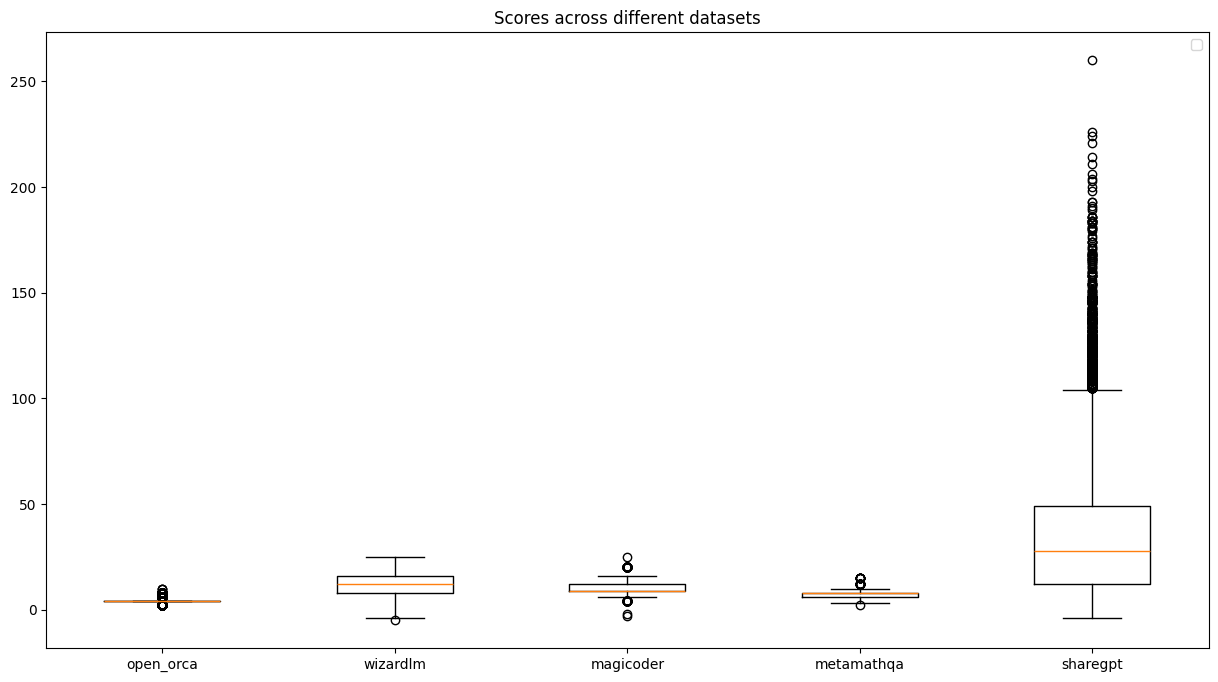

In [53]:
# plot the distribution of scores across different datasets
fig, ax = plt.subplots(figsize=(15, 8))
dataset2scores = defaultdict(list)
dataset_indices = dataset['dataset']
dataset_names = list(set(dataset['dataset']))
for dataset_name in dataset_names:
    filtered_by_dataset = dataset.filter(lambda x: x['dataset'] == dataset_name)
    dataset2scores[dataset_name] = filtered_by_dataset['eval_score']
# plot boxplot with x axis as dataset name, y axis as scores
plt.boxplot(dataset2scores.values(), labels=dataset2scores.keys())
plt.title('Scores across different datasets')
plt.legend()
plt.show()

Filter: 100%|██████████| 125000/125000 [00:03<00:00, 32487.34 examples/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


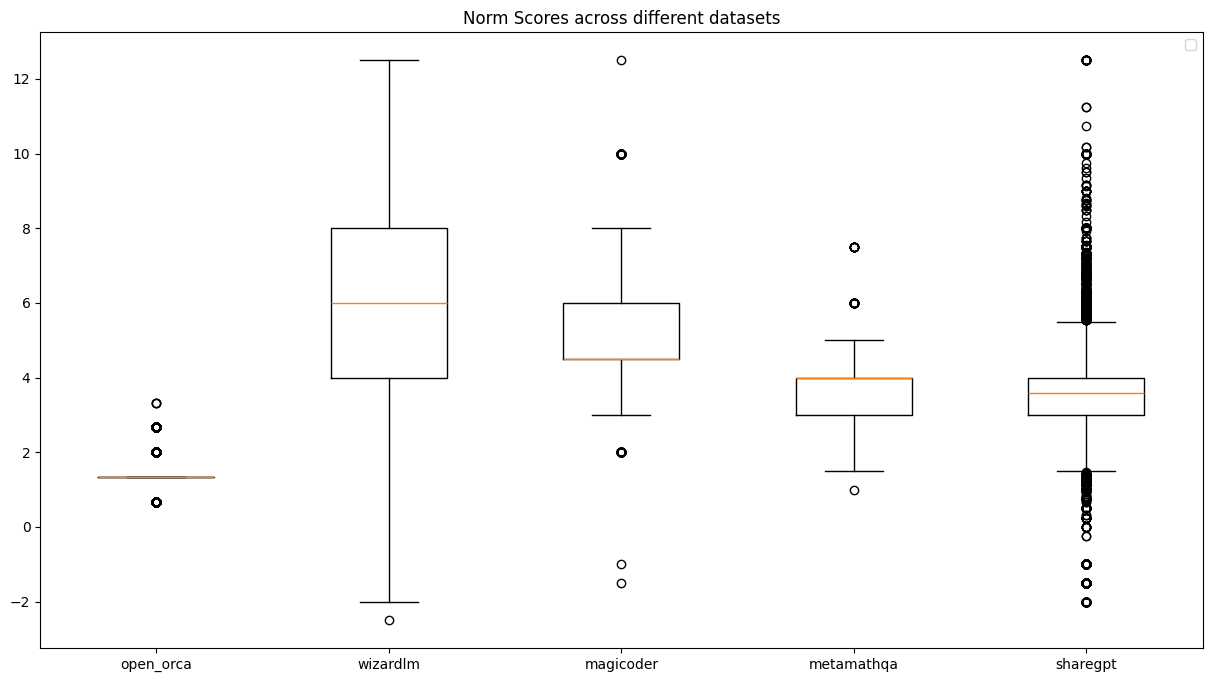

In [54]:
dataset = dataset.map(lambda x: {'norm_scores': x['eval_score'] / len(x['messages'])})

fig, ax = plt.subplots(figsize=(15, 8))
dataset2scores = defaultdict(list)
dataset_indices = dataset['dataset']
dataset_names = list(set(dataset['dataset']))
for dataset_name in dataset_names:
    filtered_by_dataset = dataset.filter(lambda x: x['dataset'] == dataset_name)
    dataset2scores[dataset_name] = filtered_by_dataset['norm_scores']
# plot boxplot with x axis as dataset name, y axis as scores
plt.boxplot(dataset2scores.values(), labels=dataset2scores.keys())
plt.title('Norm Scores across different datasets')
plt.legend()
plt.show()

In [55]:
norm_scores = dataset['norm_scores']
# save the norm_scores to the file
with open('/mnt/data/data-selection/data/processed/cohere/norm_scores.jsonl', 'w') as f:
    for score in norm_scores:
        f.write(json.dumps({'eval_score': score}) + '\n')

In [ ]:
# would deita score higher for wizardlm than sharegpt
sharegpt = load_dataset('json',
                        data_files='/mnt/data/data-selection/data/processed/sharegpt/sharegpt_data.jsonl')['train']
wizardlm = load_dataset('json',
                        data_files='/mnt/data/data-selection/data/processed/wizardlm_old/wizardlm_data.jsonl')['train']

sharegpt = sharegpt.map(lambda x: {'ori_id': x['id'].split('_')[1]})
wizardlm = wizardlm.map(lambda x: {'ori_id': x['id'].split('_')[1]})

In [ ]:
# sample 500 unique ori_id from sharegpt
sharegpt_ori_ids = np.array(sharegpt['ori_id'])
unique_sharegpt_ori_ids = np.unique(sharegpt_ori_ids)
sampled_sharegpt_ori_ids = np.random.choice(unique_sharegpt_ori_ids, 1000, replace=False)

# filter the sharegpt and wizardlm with the sampled ori_id
filtered_sharegpt = sharegpt.filter(lambda x: x['ori_id'] in sampled_sharegpt_ori_ids)
filtered_wizardlm = wizardlm.filter(lambda x: x['ori_id'] in sampled_sharegpt_ori_ids)

In [ ]:
output_path = '/mnt/data/data-selection/data/processed/sharegpt_wizardlm'
if not os.path.exists(output_path):
    os.makedirs(output_path)

with open(os.path.join(output_path, 'sharegpt_wizardlm_data.jsonl'), 'w') as f:
    for example in filtered_sharegpt:
        f.write(json.dumps(example) + '\n')
    for example in filtered_wizardlm:
        f.write(json.dumps(example) + '\n')

In [17]:
data_path = '/mnt/data/data-selection/data/processed/sharegpt_wizardlm/sharegpt_wizardlm_data.jsonl'
scores_path = '/mnt/data/data-selection/data/processed/sharegpt_wizardlm/scores.jsonl'

with open(scores_path, "r") as f:
    lines = f.readlines()
scores = [json.loads(line)['eval_score'] for line in lines]
eval_scores = np.array(scores, dtype=np.int64)

data = load_dataset('json', data_files=data_path)['train']
eval_scores = eval_scores[:len(data)]

In [18]:
data = data.add_column('eval_score', eval_scores)
data

Dataset({
    features: ['dataset', 'id', 'messages', 'ori_id', 'eval_score'],
    num_rows: 3092
})

In [24]:
# sample three ori_id and plot the distribution of scores among datasets
unique_sharegpt_ori_ids = list(set(data['ori_id']))
sampled_ori_ids = np.random.choice(unique_sharegpt_ori_ids, 15, replace=False)
sampled_data = data.filter(lambda x: x['ori_id'] in sampled_ori_ids)

Filter: 100%|██████████| 3092/3092 [00:00<00:00, 22955.27 examples/s]


In [26]:
df = sampled_data.to_pandas()
# group by ori_id and add a new column as the mean of eval_score across datasets: "{'sharegpt': [1, 2, 3], 'wizardlm': [4, 5, 6]}"
df = df.groupby('ori_id').agg({'eval_score': list}).reset_index()
df['eval_score'] = df['eval_score'].apply(lambda x: {d: np.mean(x) for d, x in zip(['sharegpt', 'wizardlm'], x)})
df

,ori_id,eval_score
0,3ktwkYA,"{'sharegpt': 22.0, 'wizardlm': 8.0}"
1,8OCFfXN,{'sharegpt': 14.0}
2,AkVr3jK,{'sharegpt': 12.0}
3,HMdLf06,{'sharegpt': 8.0}
4,IpRsuvi,"{'sharegpt': 16.0, 'wizardlm': 26.0}"
5,IqlftfZ,{'sharegpt': 6.0}
6,Kv8mRL8,"{'sharegpt': 1.0, 'wizardlm': 8.0}"
7,LXAAH8k,{'sharegpt': 10.0}
8,URTZtg9,"{'sharegpt': 6.0, 'wizardlm': 16.0}"
9,Xmta61B,"{'sharegpt': 20.0, 'wizardlm': 25.0}"


In [37]:
# filter the one that ori_id == "3ktwkYA"
test_df = data.filter(lambda x: x['ori_id'] == "3ktwkYA").to_pandas()
test_df.iloc[1]['messages']

array([{'role': 'user', 'content': 'How can the application of PYTHON be optimized for quantitative trading, specifically with regards to the implementation of algorithmic models and statistical analysis?'},
       {'role': 'assistant', 'content': 'There are several ways to optimize the application of Python for quantitative trading:\r\n\r\n1. Use efficient data structures: The choice of data structures can have a significant impact on the speed of the code. For example, using NumPy arrays instead of lists can result in faster computations.\r\n\r\n2. Parallel processing: Python has several libraries such as multiprocessing, Dask and joblib which can help you run multiple processes simultaneously, this can improve the speed of computations when running time-consuming models or backtesting.\r\n\r\n3. Vectorization: Vectorization is another way to speed up calculations by performing operations on arrays instead of individual values. This can be done using libraries such as NumPy, SciPy an